# Running Through EAZY Py

##### Made by Eddie Cunning, 2024 Honours Project

This is an individual testing notebook, testing one template suite at a time.
You choose a field, and a catalogue key, and the notebook will run through the EAZY process, outputting a variety of graphs and data.
Further, there is an agn_sed component, this is where you can select which AGN templates you want to use, and the use_galaxy_templates component, which allows you to use galaxy templates as well as AGN templates. The number valeus are as the templates appear in the file explorer, so the first template is 0, the second is 1, and so on.
catalogue_prepare.ipynb can be used to prepare a catalogue for testing.


In [1249]:
%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import eazy.hdf5
import time
import importlib
import sys
import eazy
import astropy.stats
import prospect
import math
import global_settings as gs
import pickle
import seaborn as sns
import random as rand
from importlib import reload
reload(gs)

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect', 'pandas']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

EAZYCODE = None

Tue Oct  1 12:40:57 2024

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]

               numpy : 1.22.4
               scipy : 1.11.4
          matplotlib : 3.8.4
             astropy : 5.1
                eazy : 0.6.8
            prospect : 1.0.0
              pandas : 2.1.4


Test Settings Cell, can find more in depth changes further down, or in base.param file

In [1250]:
# Load ZFOURGE catalogue from local drive
test_title = 'test_8' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs2' #'cdfs', 'cosmos', or 'uds'

# Choose ID key for the catalogue
# A key designates what type of test you want to occur, set them in global_settings.py
id_key = 'normal' # normal, high or low

# Directories for key, name keys anything, it is just to keep track of any complex object choices made in catalogue_prepare.ipynb
id_key_dict = gs.get_id_dict(field)

template_key = 'atlas_all'

template_key_dict = gs.get_template_dict()

# AGN templates allocation
# agn_sed = [] # AGN templates to be added, comma separated list. OR write 'all' to use all templates
agn_sed = 'all' # all templates within the agn_dir
agn_dir = template_key_dict[template_key] # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)
templates_use = gs.check_template(agn_sed=agn_sed, agn_temp_all=agn_temp_all)


# EAZY Parameters. There are more set below, dependent on values set later in this workbook, and more free to change in base.param
# Brown use single template fits, composite templates and no magnitude prior

standard_fit = True # set to True to use standard fit, False to use brown fit
params = {} # setting field specific parameters
if standard_fit:
    use_galaxy_templates = True # set to True to use galaxy templates as well
    params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit, 0.005 default
    params['TEMPLATE_COMBOS'] = 'a' #1 single template fit 2 pairs of templates as defined in templates file −2 all pair combinations or a for all, it is a as default
    params['APPLY_PRIOR'] = 'y' # apply the prior, y as default
else:
    use_galaxy_templates = False # set to True to use galaxy templates as well
    params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit, 0.005 default
    params['TEMPLATE_COMBOS'] = 1 #1 single template fit 2 pairs of templates as defined in templates file −2 all pair combinations or a for all, it is a as default
    params['APPLY_PRIOR'] = 'n' # apply the prior, y as default

# Spectroscopic Redshift limits
zmax = 6
zmin = 0.001

In [1251]:
# finding/creating the output directories
# Where to Save number data
output_location = 'G:/honours/outputs'
output_directory = gs.save_directory(output_location, field, test_title, id_key, template_key, agn_sed, use_galaxy_templates, params['Z_STEP'], params['TEMPLATE_COMBOS']) # output directory

AGN Data Analysis

(0.01, 1000.0)

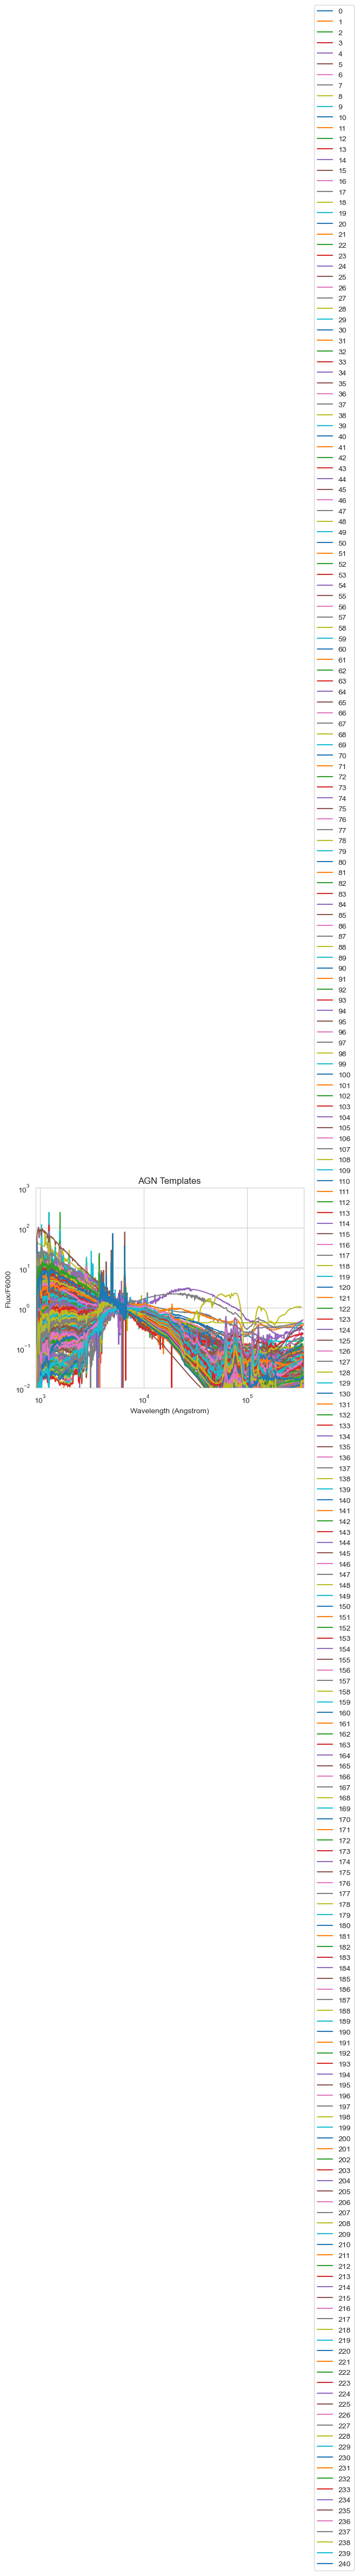

In [1252]:
#plotting all the templates used
plt.clf()
for i in templates_use:
    template_data = pd.read_csv(f'{agn_dir}{agn_temp_all[i]}', sep='\s+', header=None)
    flux_position =  abs(template_data[0] - 6000).idxmin()
    flux_normal = template_data[1][flux_position]
    plt.plot(template_data[0], template_data[1] / flux_normal, label=f'{i}')
plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux/F6000')
plt.title('AGN Templates')
plt.xlim(900, 35e4)
plt.ylim(1e-2, 1e3)


In [1253]:
# Read the catalogue
os.getcwd()

main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
main_cat.to_csv('inputs/eazy_test.cat', index=False) # create a new catalogue, allows for change to be made in this cell

#Setting up the main catalogue
main = pd.read_csv('inputs/eazy_test.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
headers = pd.read_csv('inputs/eazy_test.cat', sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

total_count = len(main) # all objects in the range
total_count

30911

In [1254]:
# Plot of % influence from AGN on each object
agn_per_dir = f'inputs/{field}_agn_frac.txt' # file with AGN fractions for each object, prepared in catalogue_prepare.ipynb
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

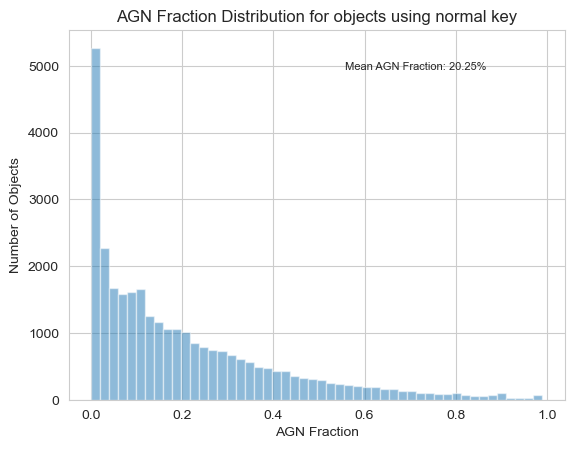

In [1255]:
has_fraction = 'bayes.agn.fracAGN' in main.columns
if not has_fraction:
    main = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object

mean_frac = np.mean(main['bayes.agn.fracAGN'])

plt.clf()
plt.hist(main['bayes.agn.fracAGN'], bins=50, alpha=0.5, label='AGN Fraction')

plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')
plt.title(f'AGN Fraction Distribution for objects using {id_key} key')
plt.text(0.7, 0.9, f'Mean AGN Fraction: {mean_frac:.2%}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig(f'{output_directory}_agn_frac.png')
plt.show()

Magnitude Distribution

In [1256]:
has_spec = main[main['z_spec'] > zmin] # filter'
has_spec = has_spec[has_spec['z_spec'] <= zmax] # filter

Running EAZY, some parameters can be changed here, look to the base.param file to adjust more

In [1257]:
# EAZY parameters

# following files should be in the same dir as the project
param_file = 'base.param' #base parameter file, does not include all information
translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

agn_param = 'templates/eazy_v1.3_AGN.param' # parameter file with agn templates
gs.agn_template_loader(templates_use, agn_param=agn_param, agn_dir=agn_dir, agn_temp_all=agn_temp_all, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

#inputs
params['TEMPLATES_FILE'] = agn_param # parameter file containing which templates will be used
params['CACHE_FILE'] = f'{output_location}/{field}/{test_title}/tempfilt_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.dat' # template cache file, not used
params['CATALOG_FILE'] = 'inputs/eazy_test.cat' # for cut catalogue created in the earlier cell
params['MAIN_OUTPUT_FILE'] = output_directory # output directory set earlier


AGN templates added to the parameter file, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

Initialize eazy.photoz.PhotoZ object

In [1258]:
# Run EAZY with parameters

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                         params=params, load_prior=True, load_products=False)

Read default param file: base.param
Read CATALOG_FILE: inputs/eazy_test.cat
   >>> NOBJ = 30911
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_KsHI e_KsHI (269): VLT/hawki_k_ETC.dat
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_U e_U (103): ESO/vimos_u.res
f_B e_B (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_V e_V (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_I e_I (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_Z e_Z (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_F140W e_F140W (204

100%|██████████| 250/250 [03:40<00:00,  1.14it/s]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Template   9: Arp_118_restframe.dat (NZ=1).
Template  10: Arp_256_N_restframe.dat (NZ=1).
Template  11: Arp_256_S_restframe.dat (NZ=1).
Template  12: CGCG_049-057_restframe.dat (NZ=1).
Template  13: CGCG_436-030_restframe.dat (NZ=1).
Template  14: CGCG_453-062_restframe.dat (NZ=1).
Template  15: Haro_06_restframe.dat (NZ=1).
Template  16: hlsp_agnsedatlas_multi_multi_2masxj13000533+1632151_multi_v1_spec-rest.dat (NZ=1).
Template  17: hlsp_agnsedatlas_multi_multi_3c120_multi_v1_spec-rest.dat (NZ=1).
Template  18: hlsp_agnsedatlas_multi_multi_3c273_multi_v1_spec-rest.dat (NZ=1).
Template  19: hlsp_agn

39it [00:01, 34.98it/s]


Iterative zeropoint corrections

Iteration:  0


100%|██████████| 39/39 [01:13<00:00,  1.89s/it]


Compute best fits
fit_best: 12.7 s (n_proc=2,  NOBJ=29131)
Fit 86.9 s (n_proc=8, NOBJ=29669)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Iteration:  1


100%|██████████| 39/39 [01:11<00:00,  1.82s/it]


Compute best fits
fit_best: 12.7 s (n_proc=2,  NOBJ=29131)
Fit 84.3 s (n_proc=8, NOBJ=29669)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Iteration:  2


100%|██████████| 39/39 [01:13<00:00,  1.88s/it]


Compute best fits
fit_best: 12.9 s (n_proc=2,  NOBJ=29133)
Fit 86.5 s (n_proc=8, NOBJ=29669)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


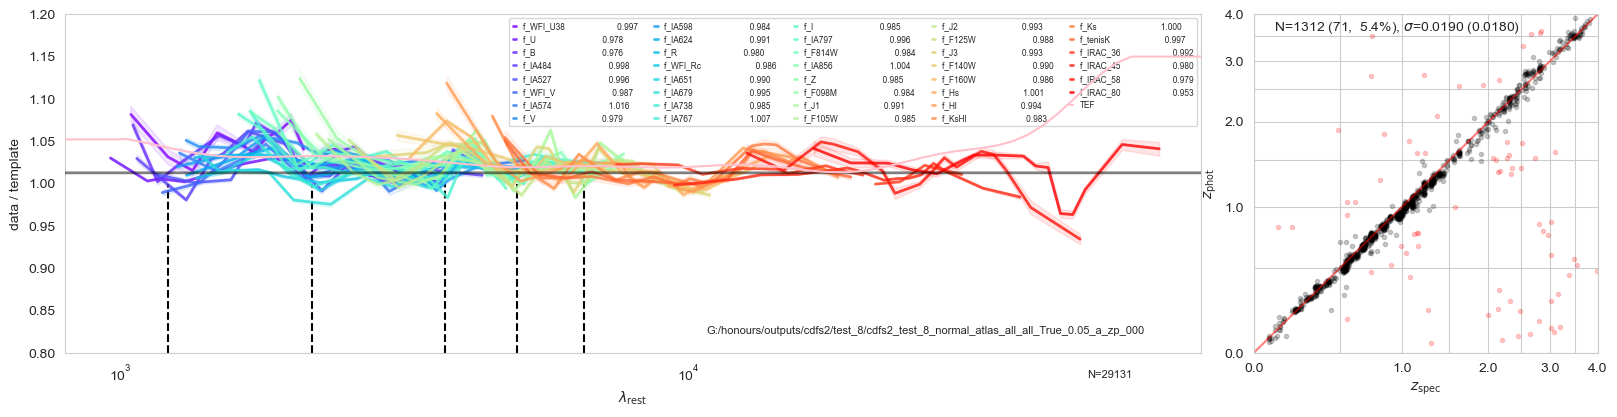

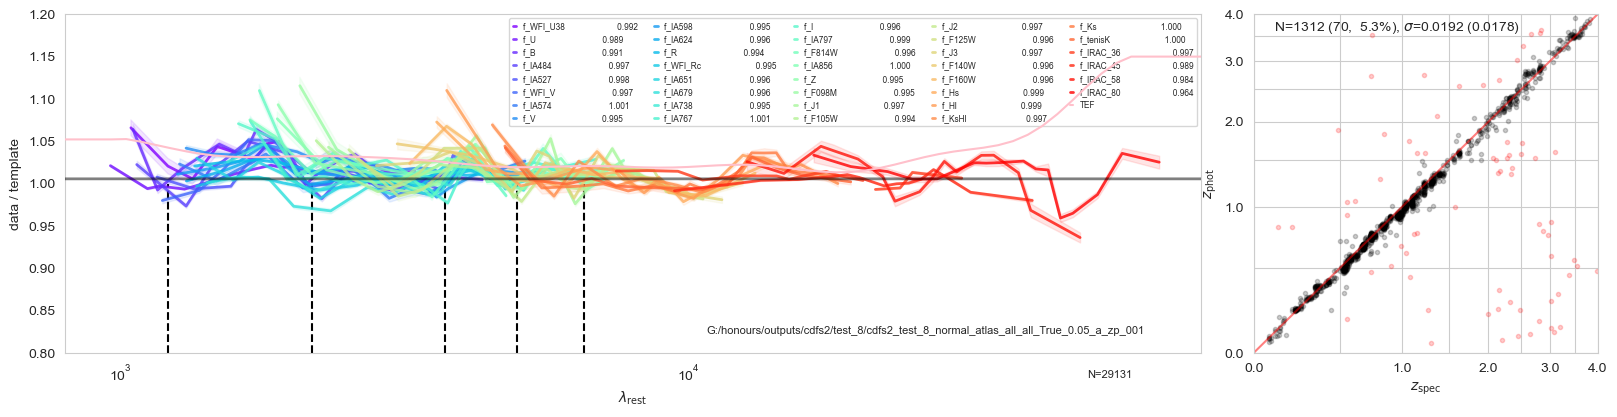

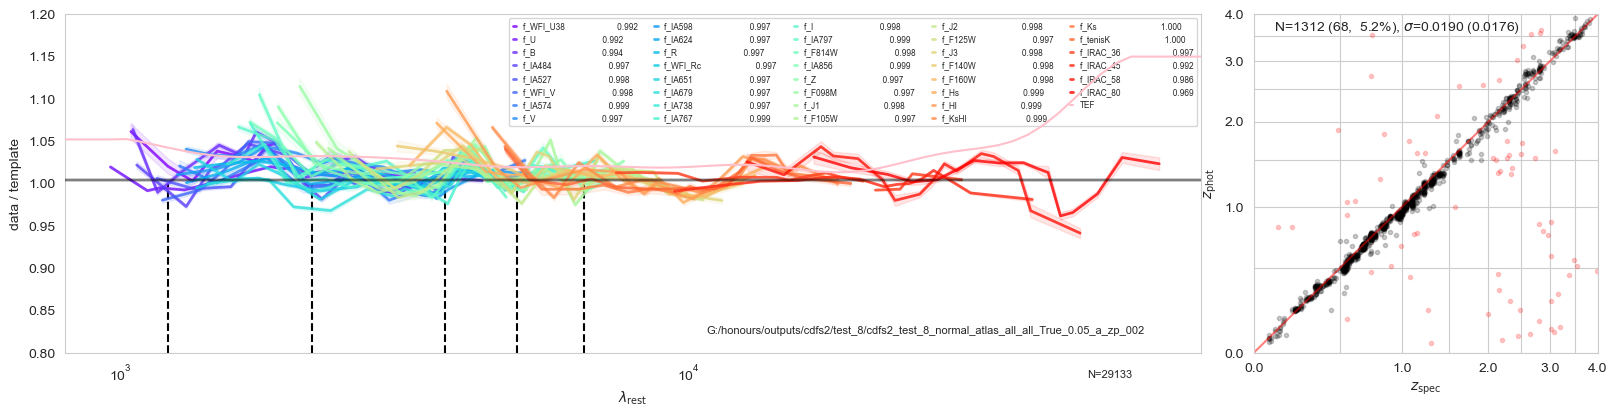

In [1259]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Now fit the whole catalog

Set sys_err = 0.00 (positive=True)


100%|██████████| 39/39 [01:12<00:00,  1.86s/it]


Compute best fits
fit_best: 10.1 s (n_proc=3,  NOBJ=30142)
Fit 83.1 s (n_proc=8, NOBJ=30911)


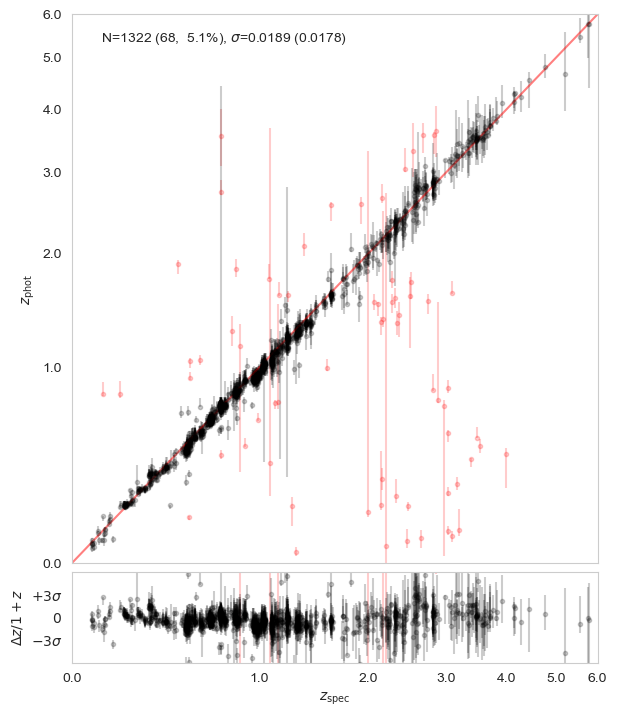

In [1260]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison

fig = self.zphot_zspec(zmax = zmax)
plt.savefig(f'{output_directory}_zphot_zspec.png')

In [1261]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
# produces a linAlg Error occasionally, wasn't needed anyway
# warnings.simplefilter('ignore', category=RuntimeWarning)
# zout, hdu = self.standard_output(simple=False,
#                                  rf_pad_width=0.5, rf_max_err=2,
#                                  prior=True, beta_prior=True,
#                                  absmag_filters=[],
#                                  extra_rf_filters=[])

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

UVJ Plots

In [1262]:
# Show UVJ diagram
# see comment in above cell
# uv = -2.5*np.log10(zout['restU']/zout['restV'])
# vj = -2.5*np.log10(zout['restV']/zout['restJ'])
# ssfr = zout['sfr']/zout['mass']
#
# sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
# plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel],
#             vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')
#
# #plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
# plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')

Initial Statistics

In [1263]:
main['ZSPEC'] = self.ZSPEC; main['ZPHOT'] = self.zbest # adding zspec and zphot to the agn_frac df
main['chi2'] = self.chi2_best / self.NFILT # adding chi2/N to the main df

#sort main df by zspec
main_red = main[main['ZSPEC'] > zmin] # filter
main_red = main_red[main_red['ZPHOT'] > 0.02] # filter
main_red = main_red[main_red['ZSPEC'] <= zmax] # filter
main_red = main_red.sort_values(by='ZSPEC') # sort

#sort main df by agn fraction
main_agn = main_red.dropna(subset=['bayes.agn.fracAGN']) # filter
main_agn = main_agn.sort_values(by='bayes.agn.fracAGN') # sort

# Scatter and Outlier
catastrophic_limit = 0.15 # limit for catastrophic outliers
self.crps_val = gs.crps(self.lnp, self.zgrid, self.ZSPEC, zmin)
mean_CRPS = np.mean(self.crps_val[self.crps_val >= 0])
total_nmad, outlier_nmad, outlier_count, outlier_fraction = gs.nmad_calc(main_red['ZPHOT'], main_red['ZSPEC'], outlier=True)
outlier_scatter = gs.rms_calc(main_red['ZPHOT'], main_red['ZSPEC'], outlier=True)
bias = np.median(main_red['ZPHOT'] - main_red['ZSPEC'])
spec_count = len(main_red['ZSPEC'])
print(f'Total NMAD: {total_nmad}')
print(f'Outlier NMAD: {outlier_nmad}')
print(f'Total Outliers:{outlier_count}')
print(f'Outlier Fraction: {outlier_fraction}')
print(f'Outlier Scatter: {outlier_scatter}')
print(f'Bias: {bias}')
print(f'Mean CRPS: {mean_CRPS}')

Total NMAD: 0.018861174469380477
Outlier NMAD: 0.017755278189788188
Total Outliers:68
Outlier Fraction: 0.05143721633888043
Outlier Scatter: 0.025518985515522848
Bias: -0.013348871469497647
Mean CRPS: 0.13322774282646438


Array Showing Worst Fits, Used in Graphing

In [1264]:
all_zphot_zspec = pd.DataFrame({'id':self.idx, 'zspec':self.ZSPEC, 'zphot':self.zbest, 'agn_fraction':main['bayes.agn.fracAGN']})
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zspec'] > 0.005] #setting minimums for the redshifts
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zphot'] > 0.02]
all_zphot_zspec['compare'] = (all_zphot_zspec['zphot'] - all_zphot_zspec['zspec']) / ( 1 + all_zphot_zspec['zspec'])

Colour Colour

In [1265]:
#Colour Plot with each template (maybe a range around them), and then each object plotted, to see how well these templates cover the objects, in the observed frame

colours = ['IRAC_36', 'IRAC_45', 'IRAC_58', 'IRAC_80'] # colours to be used, dictates loops and filter responses
columns = ['id', 'agn_fraction', 'red_diff'] + colours # columns to be used in the dataframe
used_colours = pd.DataFrame(columns=columns)

for i in range(len(colours)):
    used_colours[colours[i]] = main[f'f_{colours[i]}']

used_colours['id'] = main['id']
used_colours['agn_fraction'] = main['bayes.agn.fracAGN']
used_colours['red_diff'] = all_zphot_zspec['compare']

no_negative_mask = ~used_colours[colours].lt(0).any(axis=1)
used_colours = used_colours[no_negative_mask] #remove -99 values

used_colours['x'] = np.log10(used_colours['IRAC_58']/used_colours['IRAC_36'])
used_colours['y'] = np.log10(used_colours['IRAC_80']/used_colours['IRAC_45'])
#Template colours

filters_values = {'IRAC_36': 35569, 'IRAC_45': 45020, 'IRAC_58': 57450, 'IRAC_80': 79158}

def template_colour_redshift(template, redshift):
    """
    Function to calculate the colours of a template at a given redshift
    template: template number
    redshift: redshift of the object
    """

    template_data_pre = pd.read_csv(f'{agn_dir}{agn_temp_all[template]}', sep='\s+', header=None)

    template_data_shifted = pd.DataFrame(columns=['wavelength', 'flux'])
    template_data_shifted['wavelength']= (redshift * template_data_pre[0]) + template_data_pre[0] #redshifting the template
    template_data_shifted['flux'] = template_data_pre[1]

    temp_filt_flux_all = pd.DataFrame(columns=[colours])

    for j in range(len(colours)):
        # finds what flux best correlates with the wavelength pivot of the given filter
        min_location = abs(template_data_shifted['wavelength'] - filters_values[colours[j]]).idxmin()
        temp_filt_flux = template_data_shifted['flux'][min_location]
        temp_filt_flux_all[colours[j]] = [temp_filt_flux]

    return temp_filt_flux_all

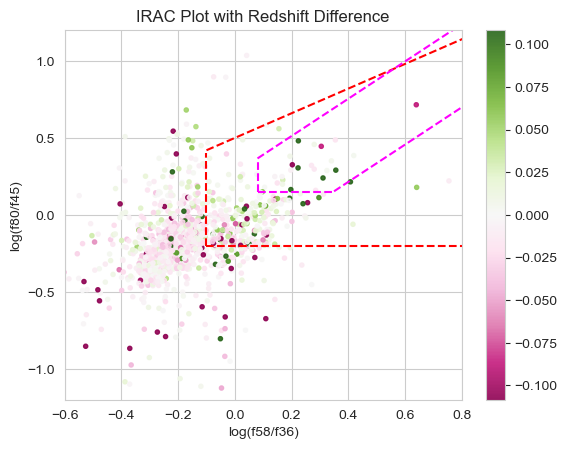

In [1266]:
# IRAC plot
import matplotlib.colors as colors

plt.clf()
three_sig_limit = used_colours['red_diff'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['red_diff'], cmap='PiYG', norm=norm, marker='.', alpha=0.9)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with Redshift Difference')

# Plot Lacy Lines
x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')

# Define functions for boundary lines
def line1(x):
    return 1.21 * x - 0.27
def line2(x):
    return 1.21 * x + 0.27

# Generate x values for plotting lines
x_values1 = np.linspace(0.08, max(used_colours['x']), 100)
x_values2 = np.linspace(0.35, max(used_colours['x']), 100)

# Plot the lines
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')

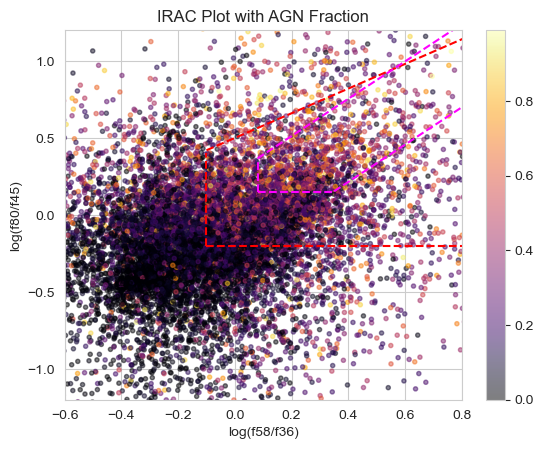

In [1267]:
# IRAC plot
plt.clf()
plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['agn_fraction'], cmap='inferno', marker='.', alpha=0.5)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with AGN Fraction')

# Plot the lines
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')

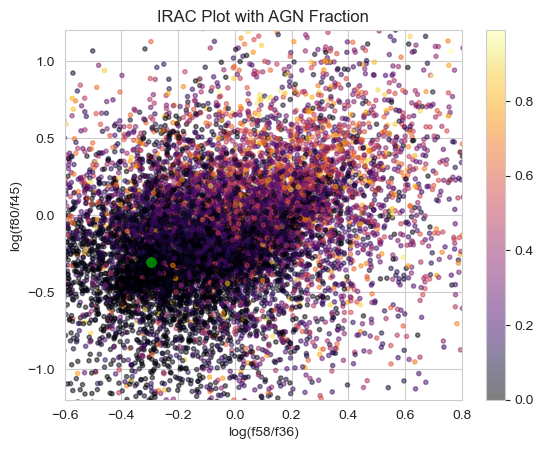

In [1268]:
# PLot With Template Colours shown
plt.clf()
plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['agn_fraction'], cmap='inferno', marker='.', alpha=0.5)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with AGN Fraction')

templates_graph = templates_use # templates to be plotted
redshift_graph = np.linspace(0, 5, 50) # redshifts to be plotted
for i in range(len(templates_graph)):
    for j in range(len(redshift_graph)):
        temp_redshift = template_colour_redshift(templates_graph[i], redshift_graph[j])
        temp_redshift.to_numpy()
        temp_redshift['x_axis'] = np.log10(used_colours['IRAC_58']/used_colours['IRAC_36'])
        temp_redshift['y_axis'] = np.log10(used_colours['IRAC_80']/used_colours['IRAC_45'])
        plt.plot(temp_redshift['y_axis'], temp_redshift['x_axis'],marker='o', c='green')


Redshift Plot with AGN fraction

Text(0.25, 0.85, 'Outliers: 68 / 1322 : 5.14%')

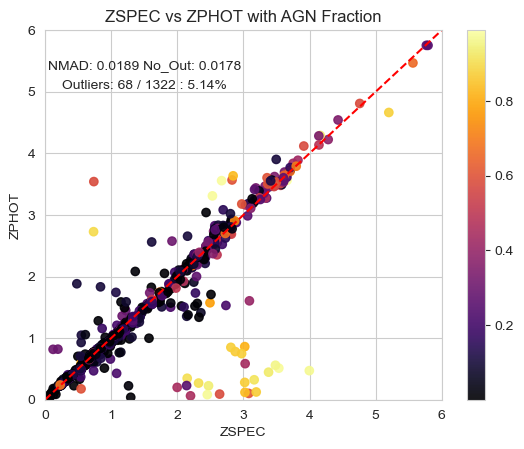

In [1269]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['zphot'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 6], 'r--')
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT')
plt.title('ZSPEC vs ZPHOT with AGN Fraction')
plt.colorbar()
plt.text(0.25, 0.9, f'NMAD: {total_nmad:.4f} No_Out: {outlier_nmad:.4f}', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.25, 0.85, f'Outliers: {outlier_count} / {len(all_zphot_zspec)} : {outlier_fraction:.2%}', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


RedShift Difference Vs AGN Fraction

Text(0.7, 0.85, 'Outliers: 68 / 1322 : 5.14%')

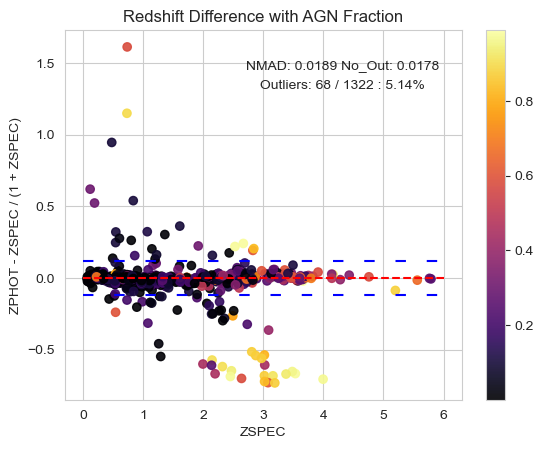

In [1270]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with AGN Fraction')
plt.text(0.7, 0.9, f'NMAD: {total_nmad:.4f} No_Out: {outlier_nmad:.4f}', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.7, 0.85, f'Outliers: {outlier_count} / {len(all_zphot_zspec)} : {outlier_fraction:.2%}', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

Text(0.5, 1.0, 'Redshift Difference with No. of Filters')

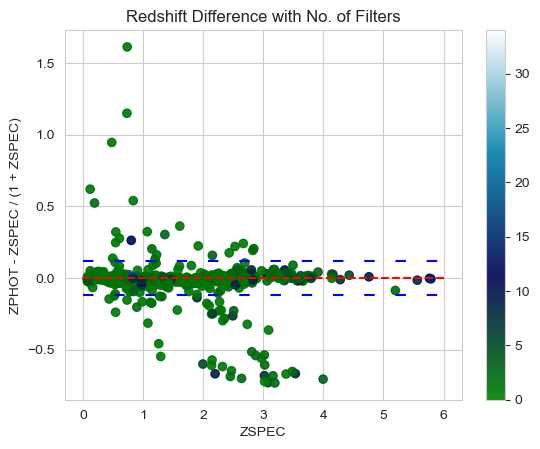

In [1271]:
# see how many filters objects are present in
filter_count = [sum(self.fnu[object_id] <= 0) for object_id in all_zphot_zspec['id']]

plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=filter_count, cmap='ocean', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with No. of Filters')

## Binned Graphs

Text(0.5, 1.0, 'Redshift Difference with Average Filter Error')

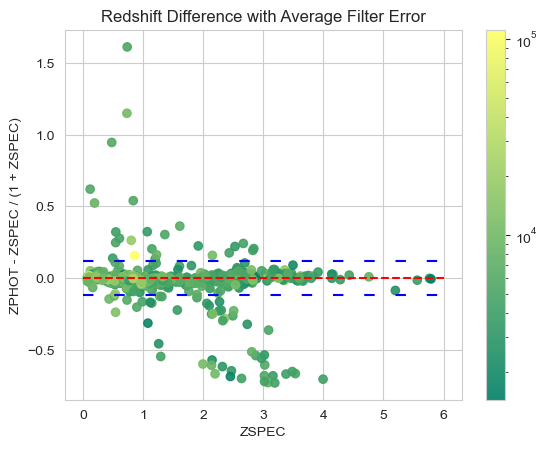

In [1272]:
# see filter error
import matplotlib.colors as colors
all_filter_error = pd.DataFrame(self.efnu).replace(99, np.nan, inplace=False)
filter_error = [np.mean(all_filter_error.loc[object_id, :]) for object_id in all_zphot_zspec['id']]

plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=filter_error,
            norm=colors.LogNorm(vmin=min(filter_error), vmax=max(filter_error)),
            cmap='summer', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with Average Filter Error')

In [1273]:
max(filter_error)

110909.516

In [1274]:
# worst fits
worst_fits = abs(all_zphot_zspec['compare'])
worst_fits = worst_fits.sort_values(ascending=True)
worst_fits.head(20)

15839    0.000016
24371    0.000026
6476     0.000071
5922     0.000072
16680    0.000128
26804    0.000153
23920    0.000189
21401    0.000195
21425    0.000205
17205    0.000216
14519    0.000217
12108    0.000237
10272    0.000239
25335    0.000252
21567    0.000263
8521     0.000274
16503    0.000308
9446     0.000323
20239    0.000335
11497    0.000335
Name: compare, dtype: float64

Counts: [  7  11   5  26  30  62 103 288 210 239  76 106  98  55   6]
Total: 1322
NMAD: [0.012096660857846053, 0.025998314344470187, 0.010737623272048628, 0.00570591650479344, 0.009818336972685145, 0.01320353237619851, 0.016022868391665515, 0.01263936693602352, 0.01656972736250219, 0.01621329327674877, 0.014428139113703378, 0.02931063097875921, 0.037734803707810065, 0.01890293980854993, 0.018699013887613216]
Outliers: [0.0, 0.09090909090909091, 0.0, 0.038461538461538464, 0.0, 0.0, 0.038834951456310676, 0.013888888888888888, 0.023809523809523808, 0.03347280334728033, 0.02631578947368421, 0.1509433962264151, 0.22448979591836735, 0.07272727272727272, 0.0]
Fits: [1.4533285, 1.5942981, 1.4301461, 1.8197663, 1.2982169, 1.0179434, 1.2046478, 1.0188551, 0.6985489, 0.84066653, 0.80556273, 1.0387284, 0.97343045, 1.0101819, 1.0049503]


<Figure size 640x480 with 0 Axes>

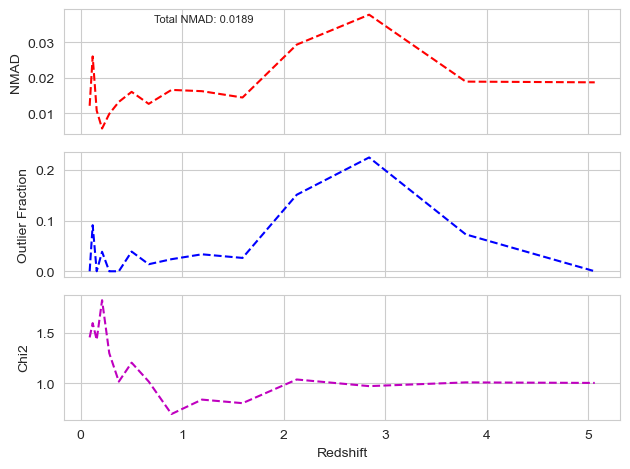

In [1275]:
no_of_bins = 15 # no. of bins
logbins_start = np.log10(min(main_red['ZSPEC'])) # using logarithmic bins
logbins_end = np.log10(max(main_red['ZSPEC'])) + 1e-10 # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
counts_red, bins_red = np.histogram(main_red['ZSPEC'], bins=logbins)
print(f'Counts: {counts_red}')
print(f'Total: {len(main_red["ZSPEC"])}')
bin_centers_red = (np.array(bins_red[:-1]) + np.array(bins_red[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_red_val = []
outlier_frac_red = []
chi2_red = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_red[bin_loop]-1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_red_val.append(astropy.stats.mad_std(dz)) # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit
    bin_fraction = sum(outliers_bin) / counts_red[bin_loop]
    outlier_frac_red.append(bin_fraction)
    chi2_med = np.median(main_red['chi2'][last_val:new_val]) # chi2
    chi2_red.append(chi2_med)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_red_val}')
print(f'Outliers: {outlier_frac_red}')
print(f'Fits: {chi2_red}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_red, nmad_red_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_red, outlier_frac_red, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_red, chi2_red, 'm--')
ax[2].set_xlabel('Redshift')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

#plt.savefig(f'{output_directory}_RED.png')
plt.show()

Counts: [725 215  96  99  58  21  22  15  11  12   9   3   6  10  10]
NMAD: [0.017171206476293218, 0.02032607239727299, 0.016073857883447375, 0.020601021888118413, 0.022960944470506384, 0.026575715592166427, 0.02101060496017853, 0.012713776828161799, 0.027864415836590467, 0.04306718222515037, 0.009646159557789495, 0.00361034060426564, 0.3062237147940127, 0.08550411086053641, 0.051121514981720136]
Outliers: [0.023448275862068966, 0.046511627906976744, 0.03125, 0.050505050505050504, 0.05172413793103448, 0.0, 0.18181818181818182, 0.0, 0.18181818181818182, 0.25, 0.0, 0.0, 0.5, 0.8, 0.8]
Fits: [0.95737064, 0.9996363, 0.9616742, 0.8825406, 0.99939924, 0.75553346, 0.8965842, 1.0489577, 1.5309658, 1.7506692, 0.72330654, 0.74922395, 1.3747753, 0.93669283, 1.1045787]


<Figure size 640x480 with 0 Axes>

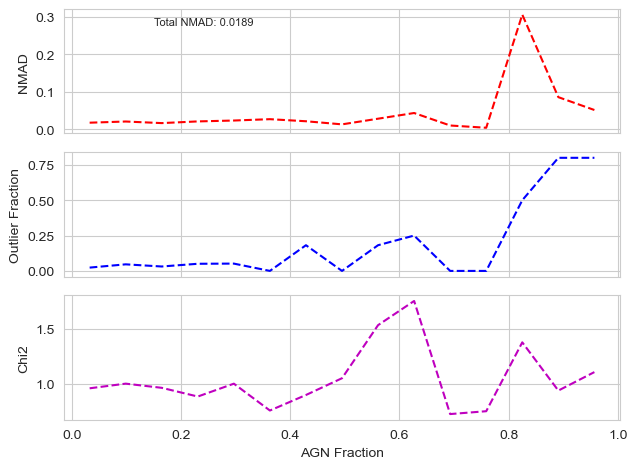

In [1276]:
#NMAD against AGN fraction

counts_agn, bins_agn = np.histogram(main_agn['bayes.agn.fracAGN'], bins=no_of_bins)
print(f'Counts: {counts_agn}')
bin_centers_agn = (np.array(bins_agn[:-1]) + np.array(bins_agn[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
outlier_frac_agn = []
chi2_agn = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_agn[bin_loop]-1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz)) # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit # outlier
    bin_fraction = sum(outliers_bin) / counts_agn[bin_loop]
    outlier_frac_agn.append(bin_fraction)
    chi2_med = np.median(main_agn['chi2'][last_val:new_val]) # chi2
    chi2_agn.append(chi2_med)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_agn_val}')
print(f'Outliers: {outlier_frac_agn}')
print(f'Fits: {chi2_agn}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_agn, nmad_agn_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_agn, outlier_frac_agn, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_agn, chi2_agn, 'm--')
ax[2].set_xlabel('AGN Fraction')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

#plt.savefig(f'{output_directory}_AGN.png')
plt.show()

## Chi 2 Graphs

Text(0.5, 1.0, 'Chi2 vs ZSPEC with Redshift Difference')

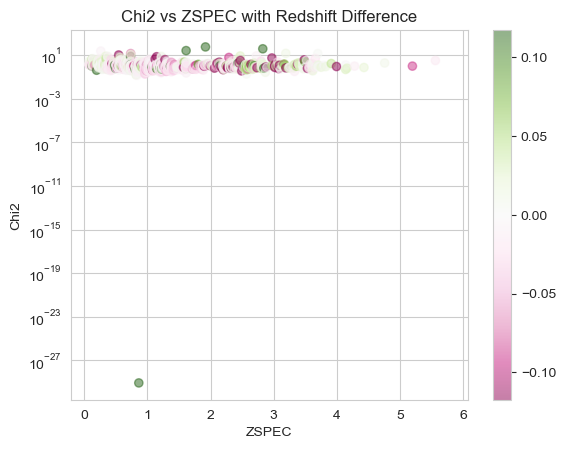

In [1277]:
# Chi 2 against Spectroscopic Redshift
main_chi2 = main_red
main_chi2['compare'] = (main_chi2['ZPHOT'] - main_chi2['ZSPEC']) / (1 + main_chi2['ZSPEC']) # redshift difference

plt.clf()
three_sig_limit = main_chi2['compare'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(main_chi2['ZSPEC'], main_chi2['chi2'], c=main_chi2['compare'], cmap='PiYG',norm=norm, alpha=0.5)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('Chi2')
plt.yscale('log')
plt.title('Chi2 vs ZSPEC with Redshift Difference')

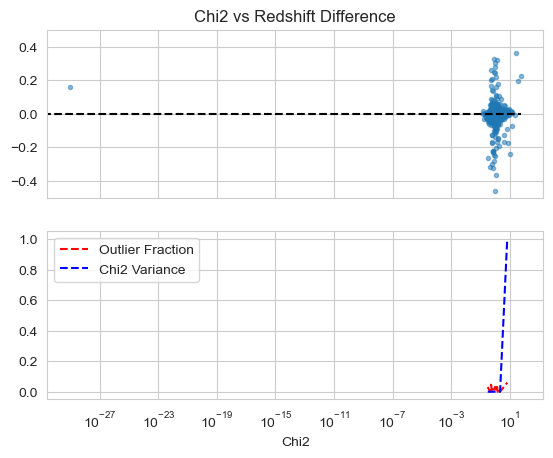

In [1278]:
no_of_bins = 20
bin_edges = pd.qcut(main_chi2['chi2'], no_of_bins)
bin_edges = bin_edges.cat.categories
chi2_bins = np.zeros([no_of_bins, 3])
for i in range(no_of_bins):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = main_chi2[(main_chi2['chi2'] >= min_loop) & (main_chi2['chi2'] <= max_loop)]
    chi2_bins[i, 0] = sum(bin_values['compare'] >= catastrophic_limit) / len(bin_values) # outlier fraction (outliers / total)
    chi2_bins[i, 1] = np.std(bin_values['chi2'])**2 # chi2 variance
    chi2_bins[i, 2] = np.mean(bin_values['chi2']) # chi2 mean

fig,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(main_chi2['chi2'], main_chi2['compare'], marker='.', alpha=0.5)
ax1.plot([0, max(main_chi2['chi2'])], [0, 0], 'k--')
#ax1.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
ax1.set_ylim(-0.5, 0.5)
ax1.set_title('Chi2 vs Redshift Difference')

ax2.plot(chi2_bins[:, 2], chi2_bins[:, 0], 'r--', label='Outlier Fraction')
ax2.plot(chi2_bins[:, 2], chi2_bins[:, 1] / max(chi2_bins[:, 1]), 'b--', label='Chi2 Variance')
ax2.legend()
ax2.set_xlabel('Chi2')
ax2.set_xscale('log')

## Redshift Vs AGN Fraction

In [1279]:
delta_z = (np.array(main_agn['ZPHOT']) - np.array(main_agn['ZSPEC'])) / (1 + np.array(main_agn['ZSPEC']))
red_agn_plot = pd.DataFrame(columns=['delta_z', 'agn_fraction'])
red_agn_plot['delta_z'] = delta_z
agn_fraction = main_agn['bayes.agn.fracAGN']
agn_fraction.index = range(len(agn_fraction))
red_agn_plot['agn_fraction'] = agn_fraction
red_agn_plot = red_agn_plot.sort_values(by=['agn_fraction'])
#red_agn_plot = red_agn_plot[abs(red_agn_plot['delta_z']) <= catastrophic_limit]

no_of_bins_red_agn = 30
bin_edges = pd.qcut(red_agn_plot['agn_fraction'], no_of_bins_red_agn)
bin_edges = bin_edges.cat.categories
red_agn_bins = np.zeros([no_of_bins_red_agn, 2])

for i in range(no_of_bins_red_agn):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = red_agn_plot[(red_agn_plot['agn_fraction'] >= min_loop) & (red_agn_plot['agn_fraction'] <= max_loop)]
    red_agn_bins[i, 0] = np.mean(bin_values['delta_z'])
    red_agn_bins[i, 1] = np.mean(bin_values['agn_fraction'])

Text(0.5, 1.0, 'Redshift vs AGN Fraction')

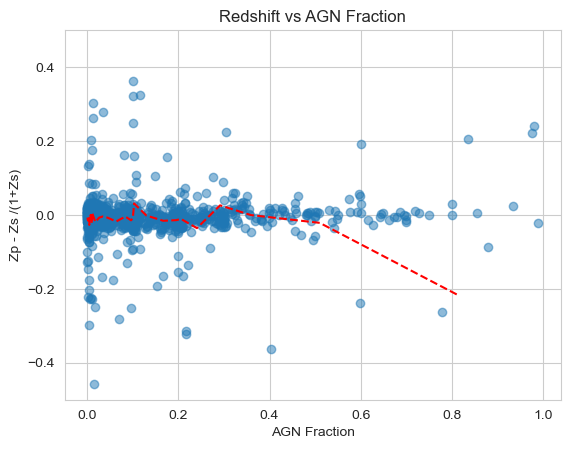

In [1280]:
plt.clf()
plt.scatter(red_agn_plot['agn_fraction'], red_agn_plot['delta_z'], alpha=0.5)
plt.plot(red_agn_bins[:, 1], red_agn_bins[:, 0], 'r--')
plt.ylim(-0.5, 0.5)
plt.xlabel('AGN Fraction')
plt.ylabel('Zp - Zs /(1+Zs)')
plt.title('Redshift vs AGN Fraction')

## Residuals

In [1281]:
#limit the no of objects to those that are present in all bands, and have a positive redshift
flux_observed = []
flux_residual_objects = []

# Filter section
filter_attendance = 39 # can miss 1 filter and still be selected
for i in range(len(self.fnu)):
    if self.ZSPEC[i] < 0.001:
        continue
    if sum(self.fnu[i] <= 0) > filter_attendance:
        continue # don't use objects where more than filter attendance filters are missing (eg. if one filter_attendance is 1, if one filter is missing it still goes forward, if two are missing it doesn't)
    else:
        flux_observed.append(self.fnu[i])
        flux_residual_objects.append(i)
flux_observed = np.array(flux_observed)

#find the residuals of the objects
flux_model = self.fmodel[flux_residual_objects]
error_observed = self.efnu[flux_residual_objects]
flux_residual = np.zeros_like(flux_observed)
residual_uncertainties = []
for row in range(len(flux_residual_objects)):
    residual_uncertainties.append(error_observed[row] / flux_observed[row])
    for col in range(flux_observed.shape[1]): #no. of bands
        if flux_observed[row,col] == -99: # if the flux is -99, it is not recorded and should not be shown as such
            flux_residual[row, col] = math.nan
        elif flux_model[row,col] == 0: # some models have no flux, this means they will be removed later
            flux_residual[row, col] = math.nan
        else:
            flux_residual[row,col] = (flux_observed[row,col] - flux_model[row,col]) / flux_observed[row,col]

#flux_residual = flux_residual[~np.isnan(flux_residual).any(axis=1)] # remove nan values
residual_uncertainties = np.array(residual_uncertainties)

#redshift the objects
object_redshifted = []
pivots = self.pivot
for i in range(len(flux_residual_objects)):
    im = flux_residual_objects[i]
    redshifted = pivots / (1 + self.ZSPEC[im])
    object_redshifted.append(redshifted)
object_redshifted = np.array(object_redshifted)

In [1282]:
pd.DataFrame(flux_model).describe()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
count,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,...,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000
mean,67.793320,42.086277,46.982784,56.832367,62.615997,62.594486,31.800007,35.448170,40.509731,49.396168,...,14.658582,17.344852,18.646437,20.315790,22.774303,8.684942,13.335377,3.295465,62.656273,62.765461
std,641.091003,144.859756,124.734665,145.813644,222.275574,222.338150,147.501434,162.429123,176.750809,199.558670,...,77.429398,86.775688,89.790596,97.361633,107.537323,51.473461,72.244804,15.337604,222.080658,221.430817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003095,0.000000,-0.000128,0.000000,0.000000
25%,4.782304,5.298003,6.084100,6.925601,6.529009,6.527669,3.700184,4.129216,4.457872,5.392709,...,1.724158,1.957007,2.085841,2.251699,2.570885,1.054987,1.591501,0.465466,6.540794,6.511532
50%,12.764337,14.289905,17.013731,20.262488,18.434142,18.429264,8.999642,9.846700,11.418596,13.619794,...,3.534988,4.406701,4.983131,5.467582,6.402750,2.192875,3.288997,1.196055,18.447438,18.503766
75%,36.942578,40.911038,47.226605,57.479331,50.555676,50.549994,22.587080,25.723776,29.560044,37.002608,...,8.752133,11.333416,12.824933,14.180958,15.743163,4.624292,7.782760,2.615287,50.606614,50.771403
max,20349.439453,3637.259766,2569.795410,3021.306152,4443.504883,4444.562988,3069.787354,3325.574951,3611.356934,4061.136963,...,1727.816162,1863.984985,1945.209473,2126.460938,2278.301514,1222.647339,1633.983032,409.430573,4440.262207,4427.556152


In [1283]:
#plot the residuals
wavelength_flat = object_redshifted.flatten()
residual_flat = flux_residual.flatten()
uncertainties_flat = residual_uncertainties.flatten()

#binning
obj_per_bin = round(0.5 * sum(self.ZSPEC > 0.001)) #EAZY used 2000
res_sorted = pd.DataFrame({'wavelength':wavelength_flat, 'residual':residual_flat, 'uncertainties':uncertainties_flat})
res_sorted = res_sorted.sort_values(by='wavelength')
res_sorted = res_sorted.dropna(how='any') # remove nan
res_std = np.std(res_sorted['residual'])
res_sorted = res_sorted[abs(res_sorted['residual']) < 3 * res_std] # remove 3sig outliers
no_of_bins_res = np.ceil(len(res_sorted) // obj_per_bin)
res_sorted = res_sorted.reset_index(drop=True)
res_sorted_copy = res_sorted # not abs
res_sorted = abs(res_sorted)
res_bin = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", "Confidence"])
res_bin_copy = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", 'Confidence'])
for i in range(int(no_of_bins_res)):
    min_loop = i * obj_per_bin
    max_loop = ((i+1) * obj_per_bin)
    med_res = np.median(res_sorted['residual'][min_loop:max_loop])
    med_res_copy = np.median(res_sorted_copy['residual'][min_loop:max_loop]) # only the residuals should be affected by abs
    med_wave = np.median(res_sorted['wavelength'][min_loop:max_loop])
    med_unc = np.median(res_sorted['uncertainties'][min_loop:max_loop])
    confidence =  (50/68.2) * 1.2533 * (np.std(res_sorted_copy['residual'][min_loop:max_loop])/np.sqrt(obj_per_bin)) # want 50% confidence interval from standard error of the median
    res_bin.loc[i] = [med_res, med_wave, med_unc, confidence]
    res_bin_copy.loc[i] = [med_res_copy, med_wave, med_unc, confidence] # copy is not abs, used in plot with negative values

In [1284]:
res_sorted.describe()

,wavelength,residual,uncertainties
count,49175.000000,49175.000000,49175.000000
mean,7472.422770,0.080718,583.781982
std,8593.832250,0.342478,6005.262207
min,561.700402,0.000000,0.000051
25%,2925.127805,0.015542,0.008347
50%,4423.638485,0.033134,0.023235
75%,8182.964195,0.061902,0.056007
max,73566.436946,13.995131,231625.187500


<Figure size 640x480 with 0 Axes>

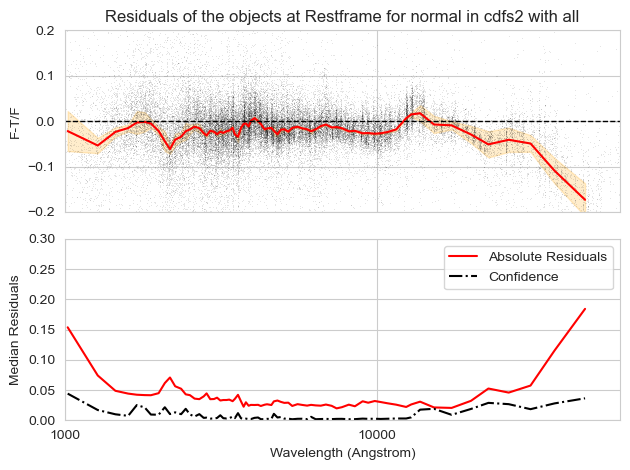

In [1285]:
plt.clf()
fig, ax = plt.subplots(2, 1, sharex=True)
fig.gca().set_xscale('log')
fig.gca().xaxis.set_major_formatter('{x:.0f}')

ax[0].plot(wavelength_flat, residual_flat, 'k,', alpha=0.1)
ax[0].plot(res_bin_copy["Median Wavelength"], res_bin_copy["Median Residuals"], 'r')
ax[0].fill_between(res_bin_copy["Median Wavelength"],
                 res_bin_copy["Median Residuals"] - res_bin["Confidence"],
                 res_bin_copy["Median Residuals"] + res_bin["Confidence"], alpha=0.2, color='orange')
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
ax[0].set_ylim(-0.2, 0.2)
ax[0].set_xlim(1e3, 6e4)
ax[0].set_ylabel('F-T/F')
ax[0].set_title(f'Residuals of the objects at Restframe for {id_key} in {field} with {agn_sed}')

ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Residuals"], 'r', label='Absolute Residuals')
# ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Uncertainties"], 'b-.', label='Uncertainties')
ax[1].plot(res_bin["Median Wavelength"], res_bin["Confidence"], 'k-.', label='Confidence')
ax[1].set_ylim(0, 0.3)
ax[1].set_ylabel('Median Residuals')
ax[1].set_xlabel('Wavelength (Angstrom)')
ax[1].legend()

fig.tight_layout()

#plt.savefig(f'{output_directory}_residuals.png')
plt.show()

## Pair Statistics

In [1286]:
# getting two pairs of physcially close objects, and seeing how large the scatter is. This removed the need for spectroscopic redshifts to produce errors.


# getting random pairs
all_obj_ids = list(main['id'])
random_pairs = []
while len(all_obj_ids) > 1:
    obj1_position = rand.randint(0, len(all_obj_ids)-1)
    obj1 = all_obj_ids[obj1_position]
    all_obj_ids.pop(obj1_position)

    obj2_position = rand.randint(0, len(all_obj_ids)-1)
    obj2 = all_obj_ids[obj2_position]
    all_obj_ids.pop(obj2_position)

    random_pairs.append([obj1, obj2])

random_redshift_differences = []

for pair in random_pairs:
    obj1 = main[main['id'] == pair[0]]
    obj2 = main[main['id'] == pair[1]]

    zphot1 = obj1['ZPHOT'].values[0]
    zphot2 = obj2['ZPHOT'].values[0]

    if zphot1 < 0.001 or zphot2 < 0.001:
        continue

    zphot_mean = (zphot1 + zphot2) / 2
    zphot_diff = (zphot1 - zphot2) / (1 + zphot_mean)

    random_redshift_differences.append(zphot_diff)

random_redshift_differences = np.array(random_redshift_differences)

In [1287]:
# now getting true pairs

pair_distance = 15 # in arcseconds

all_obj_ids = list(main['id'])
true_pairs = []
while len(all_obj_ids) > 1:
    obj1_id = all_obj_ids[0] # grabs the first id in the list
    all_obj_ids.pop(0) # removes the first id from the list
    obj1 = main[main['id'] == obj1_id]
    obj1_ra = obj1['ra'].values[0]
    obj1_dec = obj1['dec'].values[0]

    for obj2_id in all_obj_ids:
        obj2 = main[main['id'] == obj2_id]
        obj2_ra = obj2['ra'].values[0]
        obj2_dec = obj2['dec'].values[0]

        distance = 3600 * gs.angular_distance(obj1_ra, obj1_dec, obj2_ra, obj2_dec) # angular distance in arcseconds

        if distance < pair_distance:
            print(f"distance: {distance}, obj1: {obj1_id}, obj2: {obj2_id}")
            true_pairs.append([obj1_id, obj2_id])
            all_obj_ids.remove(obj2_id)
            break

true_redshift_differences = []

for pair in true_pairs:
    obj1 = main[main['id'] == pair[0]]
    obj2 = main[main['id'] == pair[1]]

    zphot1 = obj1['ZPHOT'].values[0]
    zphot2 = obj2['ZPHOT'].values[0]

    if zphot1 < 0.001 or zphot2 < 0.001:
        continue

    zphot_mean = (zphot1 + zphot2) / 2
    zphot_diff = (zphot1 - zphot2) / (1 + zphot_mean)

    true_redshift_differences.append(zphot_diff)

true_redshift_differences = np.array(true_redshift_differences)

distance: 2.884050251881399, obj1: 1, obj2: 40
distance: 7.295116044285535, obj1: 2, obj2: 13
distance: 2.049015462548155, obj1: 3, obj2: 7
distance: 7.534334421710553, obj1: 4, obj2: 18
distance: 7.764052897824122, obj1: 5, obj2: 31
distance: 1.6981918606814157, obj1: 6, obj2: 12
distance: 9.915174584310998, obj1: 8, obj2: 10
distance: 12.505437571171793, obj1: 9, obj2: 35
distance: 9.291221153190854, obj1: 11, obj2: 19
distance: 8.510845575116699, obj1: 14, obj2: 20
distance: 3.802997766518796, obj1: 15, obj2: 25
distance: 9.905226547153575, obj1: 16, obj2: 39
distance: 14.149928800948164, obj1: 17, obj2: 26
distance: 6.870109139425274, obj1: 21, obj2: 29
distance: 10.240075998703489, obj1: 23, obj2: 28
distance: 5.970562017667556, obj1: 27, obj2: 33
distance: 8.820067561074168, obj1: 30, obj2: 32
distance: 14.526157001095573, obj1: 34, obj2: 70
distance: 9.757439999869478, obj1: 36, obj2: 54
distance: 6.6262994907903, obj1: 37, obj2: 106
distance: 13.167702954815663, obj1: 38, obj2:

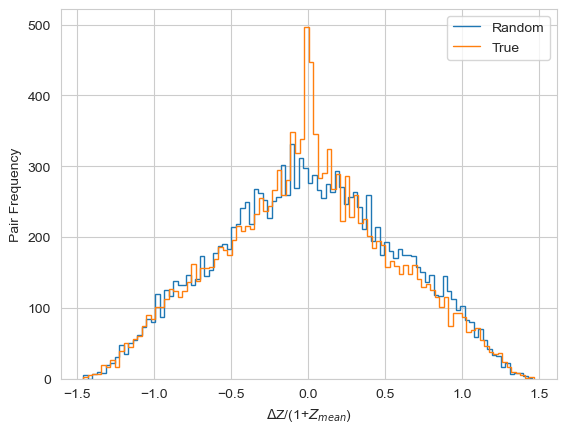

In [1288]:
plt.clf()
random_counts, bins = np.histogram(random_redshift_differences, bins=100)
plt.stairs(random_counts, bins, label='Random')
true_counts, bins = np.histogram(true_redshift_differences, bins=100)
plt.stairs(true_counts, bins, label='True')
plt.xlabel('$\Delta$Z/(1+$Z_{mean}$)')
plt.ylabel('Pair Frequency')
plt.legend()

In [1289]:
def gaussian(x, a, b):
    import numpy as np
    return a * np.exp(-(x ** 2) / (2 * b ** 2))

Text(0, 0.5, 'Pair Frequency')

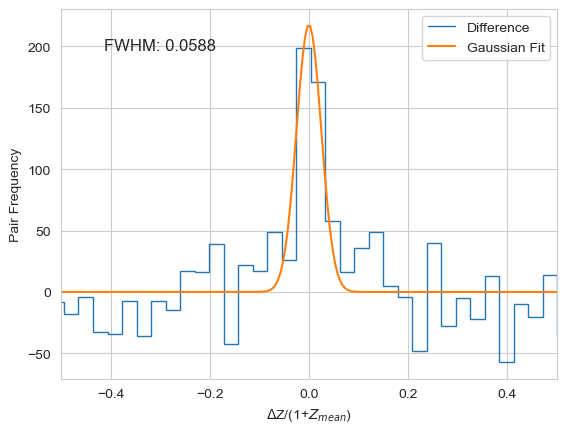

In [1290]:
from scipy.optimize import curve_fit

bin_difference = true_counts - random_counts
bin_centers = (bins[:-1] + bins[1:]) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_difference, p0=[100, 0.1])
x_model = np.linspace(-1, 1, 400)
gaussian_y_data = gaussian(x_model, *popt)

#Full Width Half Maximum
fwhm = 2 * np.sqrt((-2 * popt[1] ** 2) * np.log(0.5))

plt.clf()
plt.stairs(bin_difference, bins, label='Difference')
plt.plot(x_model, gaussian_y_data, label='Gaussian Fit')
plt.text(0.2, 0.9, f'FWHM: {fwhm:.4f}', fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlim(-0.5, 0.5)
plt.legend()
plt.xlabel('$\Delta$Z/(1+$Z_{mean}$)')
plt.ylabel('Pair Frequency')

In [1291]:
q = self.crps_val
# find index of max
max_index = np.argmax(q)
max_index

23514

## Quick look at the likelihoods

In [1292]:
# reopen self file without rerunning
#with open(f'{output_directory}_individual_data.pkl', 'rb') as file:
#    self = pickle.load(file)

Text(1.13, 0.9, 'Max lnp:0.9347\nMax my Best: 0.8993 \nZ Best: 0.8993 \nZ True: -99.0000 \nCRPS: -99.0')

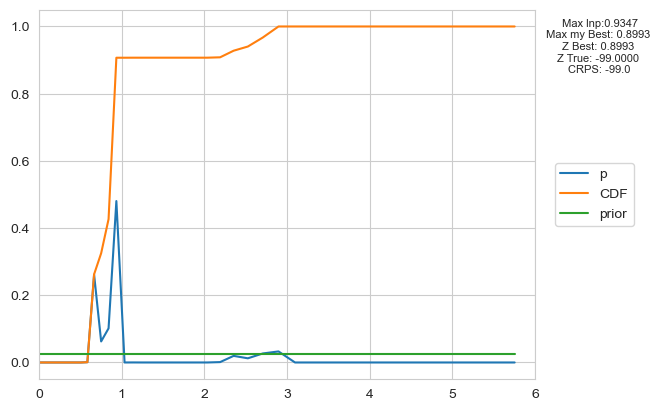

In [1293]:
object_lnp = 18


unlog_likelihood = np.exp(self.lnp[object_lnp])
unlog_prior = np.exp(self.full_logprior[object_lnp])
cdf = np.cumsum(unlog_likelihood)
plt.plot(self.zgrid, gs.normalize_by_sum(unlog_likelihood), label="p")
plt.plot(self.zgrid, gs.normalizer(cdf), label="CDF")
plt.plot(self.zgrid, gs.normalize_by_sum(unlog_prior), label="prior")
if self.ZSPEC[object_lnp] > 0:
    plt.axvline(x=self.ZSPEC[object_lnp], color='r', linestyle='--', label='Z Spec')
plt.xlim(0,6)
plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#z_lnp_max, lnp_max = self.get_maxlnp_redshift(prior=False, beta_prior=False)
my_max, my_np_max = gs.parabola_fit(self.zgrid, self.lnp[object_lnp])
eazy_z = self.zbest[object_lnp]
plt.text(1.13, 0.9, f"Max lnp:{self.zgrid[self.lnp[object_lnp].argmax()]:.4f}\n"
                   f"Max my Best: {my_max:.4f} \n"
                    f"Z Best: {eazy_z:.4f} \n"
                   f"Z True: {self.ZSPEC[object_lnp]:.4f} \n"
                   f"CRPS: {self.crps_val[object_lnp]}", fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

Saving Key data to csv and h5

In [1294]:
# Saves id, zphot, chi2, and the fluxes for each model
# individual_data = pd.DataFrame(columns=['id', 'phot_redshift', 'chi2'])
# individual_data['id'] = self.idx
# individual_data['phot_redshift'] = self.zbest
# individual_data['chi2'] = self.chi2_best
# for i in range(self.fmodel.shape[1]):
#     individual_data[f'band_{i}'] = self.fmodel[:,i]
# individual_data.to_csv(f'{output_directory}_individual_data.csv', index=False)

In [1295]:
# saves the object self
with open(f'{output_directory}_individual_data.pkl', 'wb') as file:
    pickle.dump(self, file)

In [1296]:
gs.save_key_data(output_location=output_location, field=field, test_title=test_title, key_input=[id_key, params['Z_STEP'], template_key, templates_use, use_galaxy_templates, params['TEMPLATE_COMBOS'],total_count, mean_frac, spec_count, outlier_count, total_nmad, outlier_nmad, outlier_scatter, outlier_fraction, bias, mean_CRPS])

In [1297]:
eazy.hdf5.write_hdf5(self, h5file=output_directory + '.h5')

h5: create file G:/honours/outputs/cdfs2/test_8/cdfs2_test_8_normal_atlas_all_all_True_0.05_a.h5
h5: cat/flux_columns
h5: cat/err_columns
h5: cat/f_numbers
h5: cat/fnu
h5: cat/efnu_orig
h5: cat/ok_data
h5: cat/zp
h5: cat/ext_corr
h5: cat/ext_redden
h5: cat/pivot
h5: fit/zml
h5: fit/zbest
h5: fit/chi2_fit
h5: fit/coeffs_best
h5: templates/eazy_v1.1_sed1.dat
h5: templates/eazy_v1.1_sed2.dat
h5: templates/eazy_v1.1_sed3.dat
h5: templates/eazy_v1.1_sed4.dat
h5: templates/eazy_v1.1_sed5.dat
h5: templates/eazy_v1.1_sed6.dat
h5: templates/eazy_v1.1_sed7.dat
h5: templates/c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat
h5: templates/erb2010_highEW.dat
h5: templates/Arp_118_restframe.dat
h5: templates/Arp_256_N_restframe.dat
h5: templates/Arp_256_S_restframe.dat
h5: templates/CGCG_049-057_restframe.dat
h5: templates/CGCG_436-030_restframe.dat
h5: templates/CGCG_453-062_restframe.dat
h5: templates/Haro_06_restframe.dat
h5: templates/hlsp_agnsedatlas_multi_multi_2masxj13000533+1632151_multi_v1_spec-r

In [1298]:
# These are template independent, and are only saved from template auto reload. Use the whole cat when saving these, just steals what EAZY makes really. Eazy formats from the highest wavelength to lowest, and to be consistent i just copy that.
spec_data = pd.DataFrame(columns=['id', 'zspec'])
spec_data['id'] = self.idx
spec_data['zspec'] = self.ZSPEC

filter_data = pd.DataFrame(columns=['filter', 'pivot'])
filter_data['filter'] = self.filters
filter_data['pivot'] = self.pivot

flux_data = pd.DataFrame()
for i in range(self.fnu.shape[1]):
    flux_data[f'f_band_{i}'] = self.fnu[:,i]
    flux_data[f'e_band_{i}'] = self.efnu[:,i]

# Uncomment if you want to change these files
#spec_data.to_csv(f'{output_location}/{field}/spec_data.csv', index=False)
#filter_data.to_csv(f'{output_location}/{field}/filter_data.csv', index=False)
#flux_data.to_csv(f'{output_location}/{field}/flux_data.csv', index=False)
